# A study on the timeseries forecasting method: ARIMA


## Getting the data

In [1]:
# initial imports
import pandas as pd
import numpy as np 

from TSErrors import FindErrors

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

import holidays
import calendar 

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
confirmed_global = pd.read_csv(r"./data/country_confirmed.csv")

In [3]:
def get_data(country, confirmed=confirmed_global):
    confirmed = confirmed.groupby("country").sum().T
    confirmed.index = pd.to_datetime(confirmed.index, infer_datetime_format=True)
    data = pd.DataFrame(
            index=confirmed.index, data=confirmed[country].values, columns=["Total"]
        )
    data = data[(data != 0).all(1)]

    data_diff = data.diff()

    # Removing the first value from data_diff 
    # It had no previous value and is a NaN after taking the difference
    data_diff = data_diff[1:]

    return data, data_diff

In [4]:
country = "India"
confirmed_dfs = get_data(country)
confirmed_daily = confirmed_dfs[1]

In [5]:
confirmed_daily.tail()

,Total
2022-03-04,5921.0
2022-03-05,5476.0
2022-03-06,4362.0
2022-03-07,3993.0
2022-03-08,4575.0


In [6]:
# plotting our daily cases
px.line(confirmed_daily, title=f"Daily Confirmed Cases in {country}")

In [7]:
is_holiday = [1 if i==True else 0 for i in [day in holidays.India() for day in confirmed_daily.index]]
confirmed_daily["holiday"] = is_holiday

In [8]:
day = [calendar.day_name[day.weekday()] for day in confirmed_daily.index]
confirmed_daily["day"] = day

In [9]:
df = confirmed_daily.copy()
df = df[['Total','holiday']]

In [10]:
prediction_window = 28 #testing window (4 weeks of data)
forecast_window = 7 # forecasting window (1 week)
window = prediction_window + forecast_window

In [11]:
result=adfuller(df['Total'].dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-2.6598473483947402
p-value:0.08124784990657441


In [12]:
result=adfuller(df['Total'].diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-6.599869620316604
p-value:6.778172436582615e-09


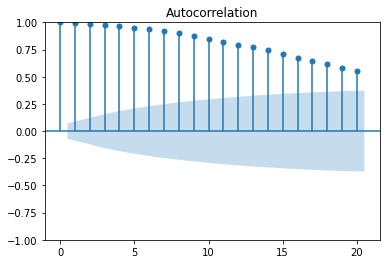

In [13]:

acf = plot_acf(df["Total"], lags=20)

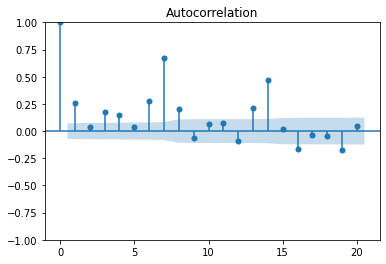

In [14]:

acf = plot_acf(df["Total"].diff().dropna(), lags=20)

In [90]:
results=pm.auto_arima(df['Total'], start_p=0, d=1, start_q=0, max_p=3, max_q=3,
                      seasonal=True, m=7, D=0, start_P=0, start_Q=0, max_P=3, max_Q=3,
                      information_criterion='bic', trace=True, error_action='ignore',
                      trend=None, exog=df['holiday'], stepwise=True, freq="D")

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=16090.383, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=15738.264, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=15784.348, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=16083.742, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=16045.608, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : BIC=15743.052, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : BIC=15743.130, Time=0.35 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : BIC=15784.313, Time=0.59 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : BIC=inf, Time=2.59 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : BIC=15756.488, Time=0.11 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : BIC=15739.665, Time=0.26 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : BIC=15618.136, Time=1.77 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : BIC=16046.629, Time=0.14 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : BIC=15612.947, Time=2.60 sec
 ARIMA(1,1,1)(3,0,0)[7] i

In [92]:
model = SARIMAX(df['Total'], order=(1,1,2), seasonal_order=(1,0,1,7), exog=df['holiday'], freq="D")
results = model.fit(method="powell")

d:\GitHub\crux-round3-tasks\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: 10.126994
         Iterations: 5
         Function evaluations: 402


In [93]:
pred = results.predict(start=len(df['Total'])-28, end=len(df['Total'])-1, exog=df["holiday"][-28:],dynamic=False)

In [94]:
FindErrors(df[-28:]["Total"], pred).mape()

14.4402743398802

In [95]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[-28:].index, y=df[-28:]['Total'], name="Actual"))
fig.add_trace(go.Scatter(x=df[-28:].index, y=pred, name="Predicted"))